<h1>Content<span class="tocSkip"></span></h1>
<div class="toc">
  <ul class="toc-item">
    <li>
      <span>
        <a href="#Prepare" data-toc-modified-id="Prepare-1">
          <span class="toc-item-num">1&nbsp;&nbsp;</span>Preparation
        </a>
      </span>
    </li>
    <li>
      <span>
        <a href="#Analysis" data-toc-modified-id="Analysis-2">
          <span class="toc-item-num">2&nbsp;&nbsp;</span>Analysis
        </a>
      </span>
    </li>
    <li>
      <span>
        <a href="#Training" data-toc-modified-id="Training-3">
          <span class="toc-item-num">3&nbsp;&nbsp;</span>Training
        </a>
      </span>
      <ul class="toc-item">
        <li>
          <span>
            <a href="#Elastic-Net" data-toc-modified-id="Elastic-Net-3.1">
              <span class="toc-item-num">3.1&nbsp;&nbsp;</span>Elastic Net
            </a>
          </span>
        </li>
        <li>
          <span>
            <a href="#LinearRegression()" data-toc-modified-id="LinearRegression()-3.2">
              <span class="toc-item-num">3.2&nbsp;&nbsp;</span>Linear regression()
            </a>
          </span>
        </li>
        <li>
          <span>
            <a href="#LGBMRegressor()" data-toc-modified-id="LGBMRegressor()-3.3">
              <span class="toc-item-num">3.3&nbsp;&nbsp;</span>LGBMRegressor()
            </a>
          </span>
        </li>
        <li>
          <span>
            <a href="#Select-better-model" data-toc-modified-id="Select-best-model-3.4">
              <span class="toc-item-num">3.4&nbsp;&nbsp;</span>Selecting optimal models
            </a>
          </span>
        </li>
      </ul>
    </li>
  </ul>
</div>

#  Forecasting taxi orders

The company "Chetenkoe taxi" collected historical data on taxi orders at airports. In order to attract more drivers during peak load, the project predicts the number of taxi orders for the next hour. A model has been built for such a prediction.

According to the conditions of the task, the value of the metric *RMSE* in the test sample should be no more than 48.

In [1]:
!pip install scikit-learn==1.0

## Preparation

In [1]:
# import
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
pd.set_option('display.max_columns', None) # make it possible to display all columns on the screen
pd.set_option('display.float_format', '{:.3f}'.format) # display float values ​​up to 3 decimal places
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder # for quantitative feature scaling + ordinal encoding
from sklearn.metrics import mean_squared_error, make_scorer #for RMSE
from sklearn.linear_model import LinearRegression # linear regression
from sklearn.ensemble import RandomForestRegressor # random forest
from sklearn.tree import DecisionTreeRegressor # decision tree
import time, catboost
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.model_selection import cross_val_score, train_test_split, TimeSeriesSplit, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error as mse
# константы заглавными буквами
RANDOM_STATE = 42
from sklearn.compose import make_column_transformer
from sklearn.linear_model import Ridge
import time
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_predict
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV

In [2]:
#import dataset
df = pd.read_csv(r'datasets/11_taxi.csv', parse_dates=[0])
df.sort_index(inplace=True)
display(df)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


In [3]:
# description function
def describe_colums(df):
    
    values = pd.DataFrame()
    
    for col in df.columns:
        values[col] = [df[col].unique(), df[col].dtypes, df[col].nunique(), df[col].isnull().sum().sum(), df.duplicated().sum()]
        
    return values.transpose().sort_values(by=1, ascending=False).rename(
        {0: 'Values', 1: 'Data type', 2: 'Unique values', 3: 'Missing', 4: 'Duplicates'}, axis=1)
describe_colums(df)

,Values,Data type,Unique values,Missing,Duplicates
datetime,"[2018-03-01T00:00:00.000000000, 2018-03-01T00:...",datetime64[ns],26496,0,0
num_orders,"[9, 14, 28, 20, 32, 21, 7, 5, 17, 12, 19, 25, ...",int64,81,0,0


There are no duplicates or omissions. You only need to change the 'datetime' datatype.

In [4]:
# change format to date
df['datetime'] = pd.to_datetime(df['datetime'], format = '%Y-%m-%d %H:%M:%S')
display(df)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


In [5]:
# Set table index to datetime column
df.set_index('datetime', inplace=True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


The dataset contains data for six months. from 03/01/2018 to 08/31/2018

In [6]:
# Checking for chronology
is_monotonic = df.index.is_monotonic
print(df.index.is_monotonic)

True


## Analysis

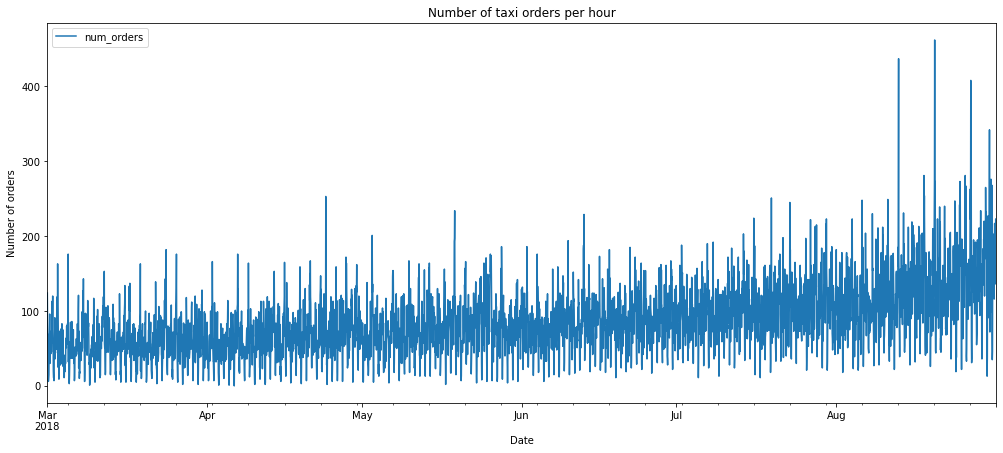

In [7]:
# Let's resample for 1 hour
df = df.resample('1H').sum() # sum over hours
# set the size of the shape
df.plot(figsize=(17, 7))
plt.title('Number of taxi orders per hour')
plt.xlabel('Date')
plt.ylabel('Number of orders')
# display the graph on the screen
plt.show()

When resemling by the clock, little is clear from the data.

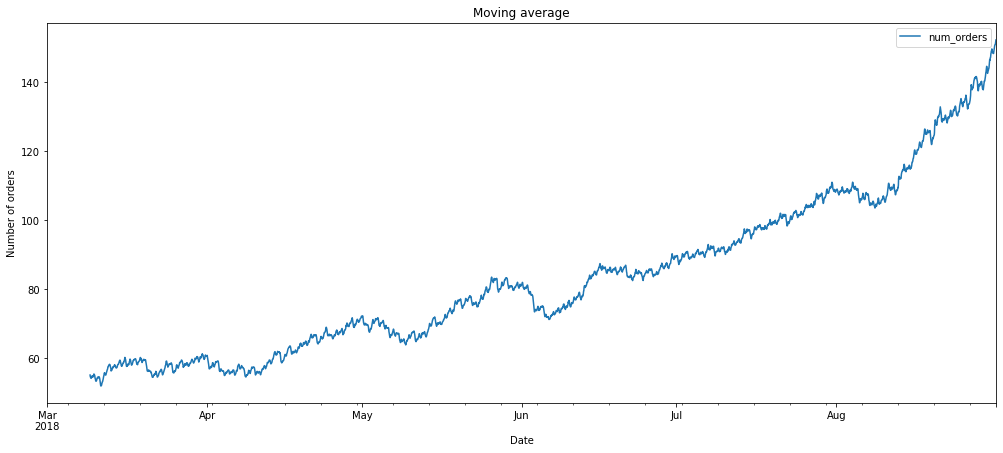

In [8]:
df.rolling(200).mean().plot(figsize=(17, 7))# reflect the moving average
plt.title('Moving average')
plt.xlabel('Date')
plt.ylabel('Number of orders')
# we display the graph on the screen
plt.show()

The general trend of increasing the number of orders is visible. Unfortunately, without data by year, it is difficult to talk about seasonality. In a general sense, the number of orders increases significantly.

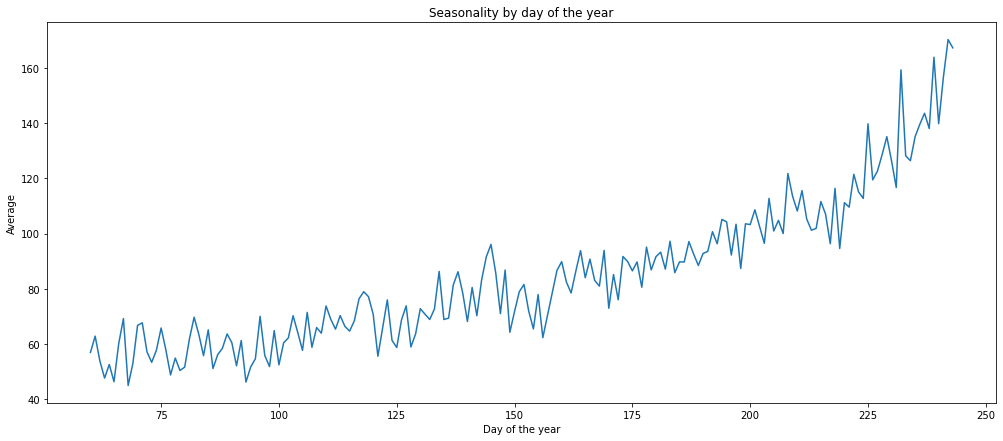

In [17]:
# Creating a new column 'dayofyear' with the day number in the year
df['dayofyear'] = df.index.dayofyear

# Create a daily seasonal chart
plt.figure(figsize=(17,7))
plt.plot(df.groupby('dayofyear')['num_orders'].mean())
plt.xlabel('Day of the year')
plt.ylabel('Average')
plt.title('Seasonality by day of the year')
plt.show()

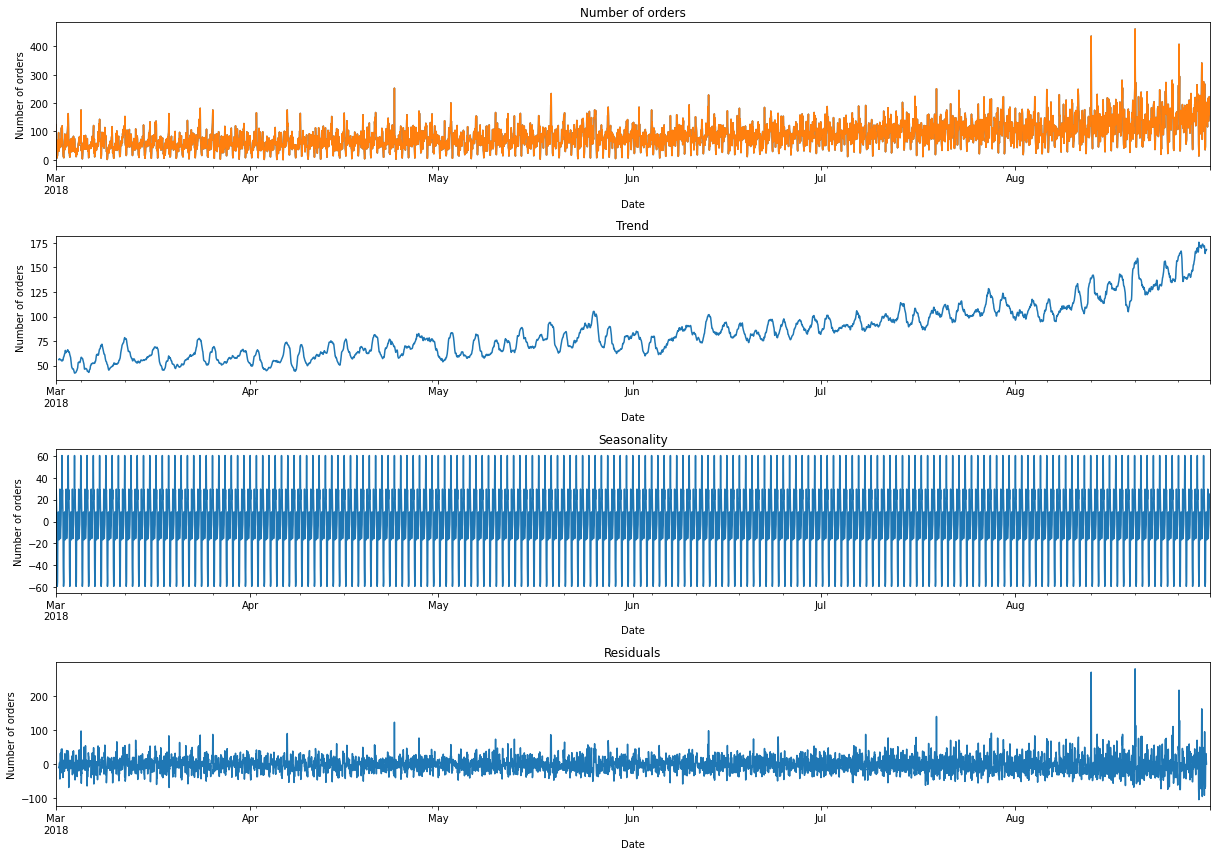

In [14]:
# calculating trend, seasonality and residuals
decomposition = seasonal_decompose(df['num_orders'], model='additive', period=24)
trend = decomposition.trend
seasonality = decomposition.seasonal
residuals = decomposition.resid

# display the results as a graph
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(17, 12))

df['num_orders'].plot(ax=ax[0])
df['num_orders'].plot(ax=ax[0])
ax[0].set_title('Number of orders')
ax[0].set_ylabel('Number of orders')
ax[0].set_xlabel('Date')

trend.plot(ax=ax[1])
ax[1].set_title('Trend')
ax[1].set_ylabel('Number of orders')
ax[1].set_xlabel('Date')

seasonality.plot(ax=ax[2])
ax[2].set_title('Seasonality')
ax[2].set_ylabel('Number of orders')
ax[2].set_xlabel('Date')

residuals.plot(ax=ax[3])
ax[3].set_title('Residuals')
ax[3].set_ylabel('Number of orders')
ax[3].set_xlabel('Date')

plt.tight_layout()
plt.show()

Cтохастический процесс является нестационарным, так как наблюдается и возрастающий тренд и сезонность. Далее рассмотрим подробнее.

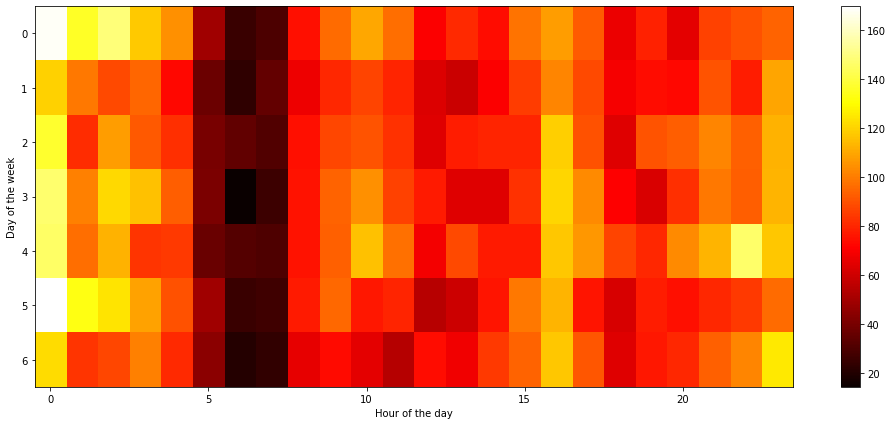

In [18]:
# add columns containing information about the day of the week and the hour
df['weekday'] = df.index.weekday
df['hour'] = df.index.hour

# create a pivot table by grouping the data by day of the week and hour and calculating the average number of orders
pivot = pd.pivot_table(df, values='num_orders', index='weekday', columns='hour', aggfunc='mean')

# display the results as a heatmap
plt.figure(figsize=(17, 7))
plt.imshow(pivot, cmap='hot', aspect='auto')
plt.xlabel('Hour of the day')
plt.ylabel('Day of the week')
plt.colorbar()
plt.show()

Having displayed the dependence on the day of the week and hour on the heat map, we see a clear pattern that most orders fall at night time, and there is a small peak at 10 am and 4 pm. And the day of the week already affects here. On weekends and at the beginning of the week, people use taxis more often, on Wednesdays there are fewer orders.

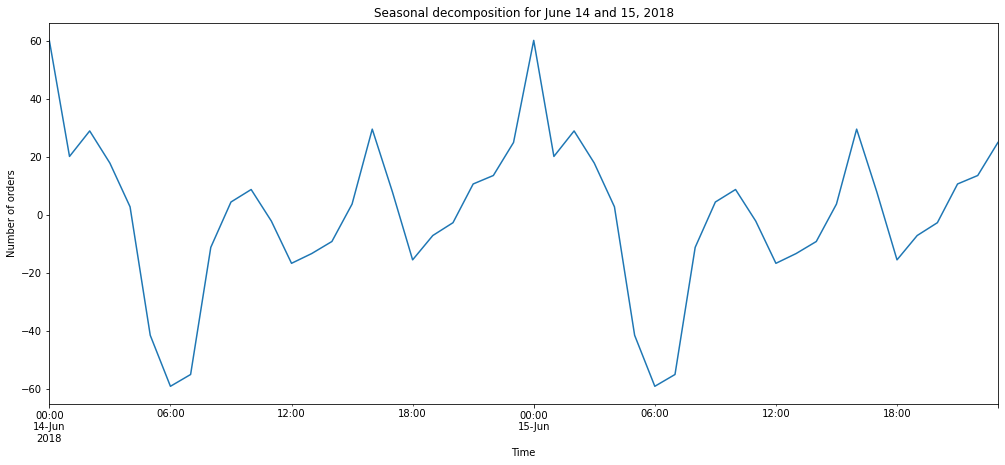

In [19]:
# time series decomposition
decomposed = seasonal_decompose(df['num_orders'], model='additive', period=24)

# set the size of the shape
fig, ax = plt.subplots(figsize=(17, 7))

# display the seasonal component for one day in June 2018
decomposed.seasonal['2018-06-14 00:00:00':'2018-06-15 23:50:00'].plot(ax=ax)
ax.set_title('Seasonal decomposition for June 14 and 15, 2018')
ax.set_ylabel('Number of orders') # y-axis name
ax.set_xlabel('Time')

# display the graph on the screen
plt.show()

We see a clearly traceable seasonality by day. Decrease in the number of orders in the morning and at 18:00, peak values around 16:00 and at night.

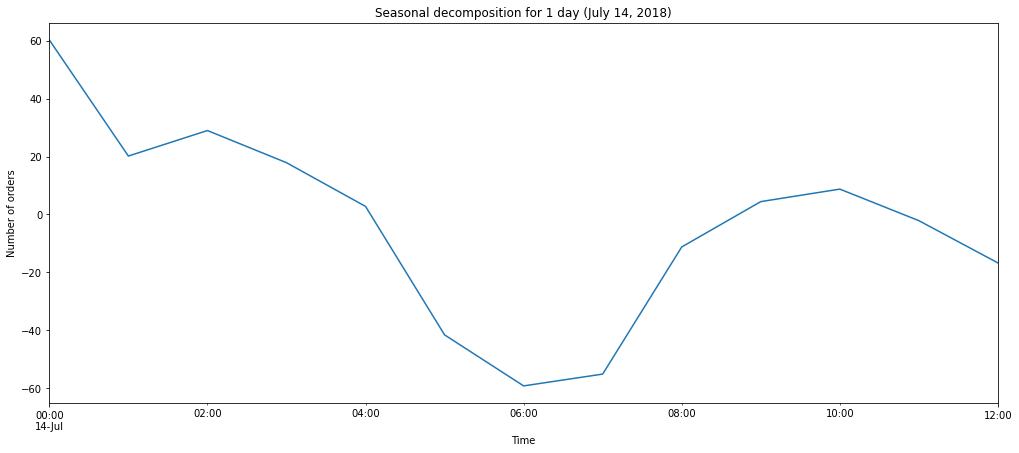

In [20]:
# time series decomposition
decomposed = seasonal_decompose(df['num_orders'], model='additive', period=24)

# set the size of the shape
fig, ax = plt.subplots(figsize=(17, 7))

# display the seasonal component for one day in August 2018
decomposed.seasonal['2018-07-14 00:00:00':'2018-07-14 12:00:00'].plot(ax=ax)
ax.set_title('Seasonal decomposition for 1 day (July 14, 2018)') # chart title
ax.set_ylabel('Number of orders') # y-axis name
ax.set_xlabel('Time')
# display the graph on the screen
plt.show()

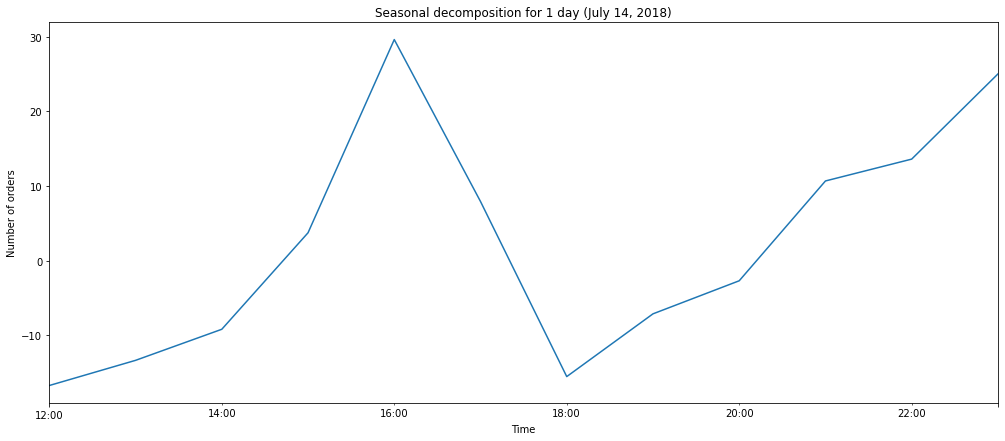

In [21]:
# set the size of the shape
fig, ax = plt.subplots(figsize=(17, 7))
# display the seasonal component for one day in August 2018
decomposed.seasonal['2018-07-14 12:00:00':'2018-07-14 23:59:59'].plot(ax=ax)
ax.set_title('Seasonal decomposition for 1 day (July 14, 2018)') # chart title
ax.set_ylabel('Number of orders') # y-axis name
ax.set_xlabel('Time')
# display the graph on the screen
plt.show()

A more detailed examination confirmed our conclusion on the seasonality of the day, revealed when considering two days.

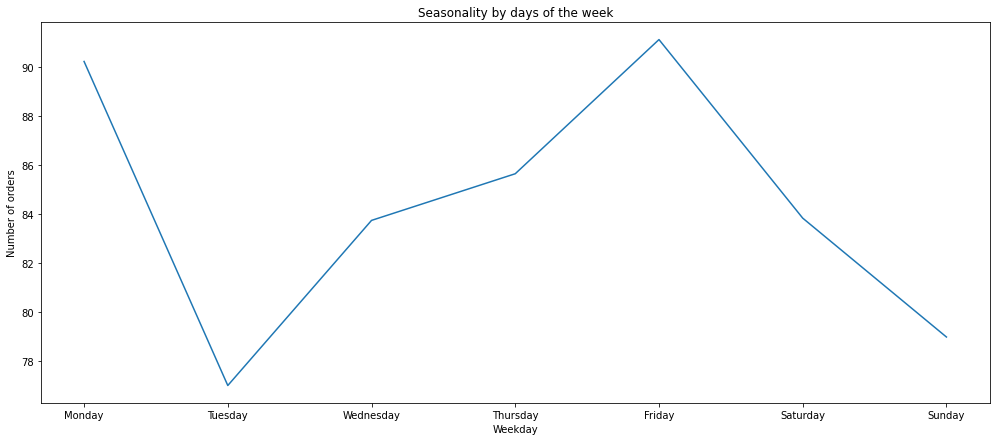

In [22]:
# set the size of the shape
fig, ax = plt.subplots(figsize=(17, 7))
# group the data by day of the week and calculate the average value of the number of orders
df_weekday = df.groupby(df.index.weekday)['num_orders'].mean()

# display a graph of the average number of orders for each day of the week
df_weekday.plot(ax=ax)
ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.set_xticks(range(7))
ax.set_xlabel('Weekday')
ax.set_ylabel('Number of orders')
ax.set_title('Seasonality by days of the week')
# display the graph on the screen
plt.show()

Most taxis are used on Friday and Monday. On Tuesday and Sunday, a clear decline.

As described above, a general trend in the growth of orders is visible. At the same time, seasonality is observed, which we found on the heat map and on a more detailed examination of the day. Seasonality depends on the days of the week and hours. Also, in August there is more noise than before.

## Training

In [23]:
df

,num_orders,dayofyear,weekday,hour
datetime,,,,
2018-03-01 00:00:00,124,60,3,0
2018-03-01 01:00:00,85,60,3,1
2018-03-01 02:00:00,71,60,3,2
2018-03-01 03:00:00,66,60,3,3
2018-03-01 04:00:00,43,60,3,4
...,...,...,...,...
2018-08-31 19:00:00,136,243,4,19
2018-08-31 20:00:00,154,243,4,20
2018-08-31 21:00:00,159,243,4,21


In [24]:
# define the make_features function
def make_features(df, max_lag, rolling_mean_size):
    df['month'] = df.index.month #add month and year
    df['day'] = df.index.day
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean() # rolling average

make_features(df, 96, 72)
df.shape

(4416, 103)

In [25]:
df.head(5)

,num_orders,dayofyear,weekday,hour,month,day,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,lag_31,lag_32,lag_33,lag_34,lag_35,lag_36,lag_37,lag_38,lag_39,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,lag_49,lag_50,lag_51,lag_52,lag_53,lag_54,lag_55,lag_56,lag_57,lag_58,lag_59,lag_60,lag_61,lag_62,lag_63,lag_64,lag_65,lag_66,lag_67,lag_68,lag_69,lag_70,lag_71,lag_72,lag_73,lag_74,lag_75,lag_76,lag_77,lag_78,lag_79,lag_80,lag_81,lag_82,lag_83,lag_84,lag_85,lag_86,lag_87,lag_88,lag_89,lag_90,lag_91,lag_92,lag_93,lag_94,lag_95,lag_96,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,60,3,0,3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,60,3,1,3,1,124.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,60,3,2,3,1,85.000,124.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,60,3,3,3,1,71.000,85.000,124.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,60,3,4,3,1,66.000,71.000,85.000,124.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
df = df.dropna()

In [27]:
df.shape

(4320, 103)

In [28]:
# highlight the features and the target value, divide the samples into test and training
features = df.drop(['num_orders'], axis=1)
target = df['num_orders']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=12345, shuffle=False) 
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=12345, shuffle=False) 


In [29]:
X_train.shape


(3456, 102)

In [30]:
y_train.shape

(3456,)

In [31]:
col_transformer = make_column_transformer(
    (StandardScaler(), X_train.columns),remainder='passthrough'
)

### Elastic Net

In [32]:
# Create a splitter object for the time series
tscv = TimeSeriesSplit(n_splits=5)
elastic_model= ElasticNetCV(l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1],cv=tscv, max_iter=100000)

In [33]:
%%time
elastic_model.fit(X_train, y_train)

CPU times: total: 93.8 ms
Wall time: 1.3 s


ElasticNetCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], max_iter=100000)

In [34]:
elastic_model.l1_ratio_

0.5

In [35]:
%%time
y_pred_elastic=elastic_model.predict(X_valid)

CPU times: total: 15.6 ms
Wall time: 5.98 ms


In [36]:
rmse_elastic = mean_squared_error(y_valid, y_pred_elastic, squared=False)
print(f'RMSE: {rmse_elastic:.4f}')

RMSE: 30.1760


### LinearRegression()

In [39]:
# Create a linear regression object
model = LinearRegression()

# Create a grid of parameters for the search
param_grid = {
    'fit_intercept': [True, False],
    'normalize': [True, False]
}

# Create a GridSearchCV object to search for the best parameters
gs_lr = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, scoring='neg_root_mean_squared_error')

In [45]:
%%time
# Train the model on the training data
gs_lr.fit(X_train, y_train)

CPU times: total: 750 ms
Wall time: 260 ms


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False],
                         'normalize': [True, False]},
             scoring='neg_root_mean_squared_error')

In [46]:
# Get the best model and predict values ​​for the validation data
best_model = gs_lr.best_estimator_

In [47]:
%time
y_pred_lr = best_model.predict(X_valid)

CPU times: total: 0 ns
Wall time: 0 ns


In [48]:
# Calculate RMSE for received predictions
rmse_lr = mean_squared_error(y_valid, y_pred_lr, squared=False)
# Display results
print(f'Best model parameters: {gs_lr.best_params_}')
print(f'RMSE: {rmse_lr:.4f}')

Best model parameters: {'fit_intercept': False, 'normalize': True}
RMSE: 30.3259


### LGBMRegressor()

In [49]:
# Create an LGBMRegressor model object and a pipeline object
model = LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-164)

# Create a grid of parameters for the search
param_grid_lgbm = {
    'learning_rate': [0.01, 0.03, 0.1],
    'max_depth': [-1, 5, 10, 15],
    'num_leaves': [10, 20, 30, 40, 50]
}


# Create a GridSearchCV object to search for the best parameters
gs_lgbm = GridSearchCV(estimator=model, param_grid=param_grid_lgbm, cv=tscv, scoring='neg_root_mean_squared_error')

In [50]:
%%time
# Use GridSearchCV to train the model on the training data and select the best parameters
gs_lgbm.fit(X_train, y_train)


CPU times: total: 10min 23s
Wall time: 1min 41s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LGBMRegressor(n_jobs=-164, random_state=42),
             param_grid={'learning_rate': [0.01, 0.03, 0.1],
                         'max_depth': [-1, 5, 10, 15],
                         'num_leaves': [10, 20, 30, 40, 50]},
             scoring='neg_root_mean_squared_error')

In [51]:
%%time
# Use the best model to predict on the validation data
y_pred_cv_lgbm = gs_lgbm.predict(X_valid)

CPU times: total: 93.8 ms
Wall time: 4.99 ms


In [52]:
# Calculate RMSE on the entire dataset
rmse_cv_lgbm = mean_squared_error(y_valid, y_pred_cv_lgbm, squared=False)

# Display results
print(f'Best model parameters: {gs_lgbm.best_params_}')
print(f'RMSE with cross-validation: {rmse_cv_lgbm:.4f}')

Best model parameters: {'learning_rate': 0.1, 'max_depth': 5, 'num_leaves': 10}
RMSE with cross-validation: 30.9806


### Choosing the best model

Let's create a pivot table that includes the studied models

In [53]:
index = ['Elastic Net',
         'LinearRegression',
         'LGBMRegressor']
table = {'RMSE':[rmse_elastic,
                rmse_lr,
                rmse_cv_lgbm],
        'Training time, sec':[5.52,
                               1.75
                               408],
        'Prediction time, sec':[0.482,
                                   0,
                                   0.438]}

scores_table = pd.DataFrame(data=table, index=index)

scores_table

SyntaxError: invalid syntax (1118645415.py, line 9)

All three models show good results. Best RMSE Shows Elastic Net/

## Testing

In [54]:
# check the prediction of the best model on the test data
y_pred_elastic_test=elastic_model.predict(X_test)

In [55]:
rmse_elastic = mean_squared_error(y_test, y_pred_elastic_test, squared=False)
print(f'RMSE: {rmse_elastic:.4f}')

RMSE: 41.3007


RMSE on test data is slightly worse, but within reasonable limits. This value also satisfies the requirements of the task.

Now compare with a stub that predicts a value from the last known value

In [56]:
df_test = pd.concat([X_test, y_test], axis=1)
predicted_previous = df_test['num_orders'].shift()
predicted_previous.shape
predicted_previous.iloc[0] = y_test.iloc[-1]
rmse_previous = mean_squared_error(y_test, predicted_previous)**0.5
print("RMSE estimate by last value:", rmse_previous )

RMSE estimate by last value: 59.24173641389433


The result of the stub is worse, which means that our model is adequate.

Now let's visualize our results.

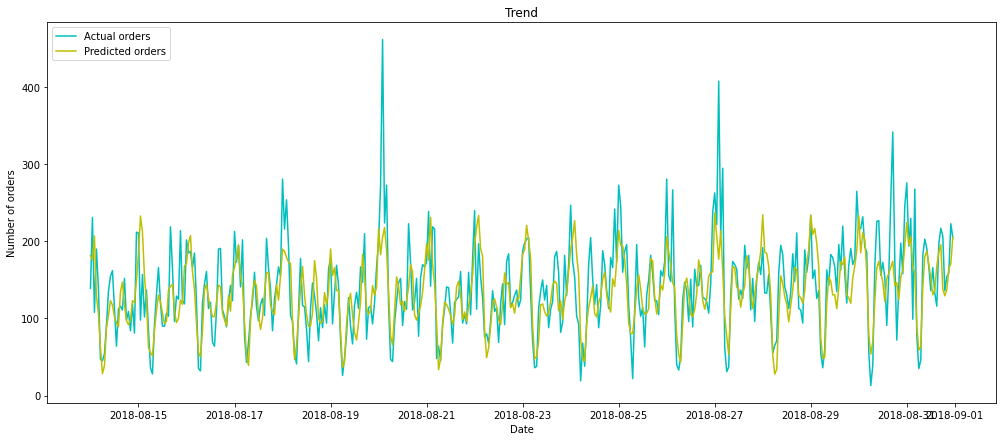

In [59]:
fig, ax = plt.subplots(figsize=(17, 7))

# add title, axis labels
ax.set_title('Trend')
ax.set_ylabel('Number of orders')
ax.set_xlabel('Date')

# adding charts
plt.plot(y_test.index, y_test, 'c-', label='Actual orders')
plt.plot(y_test.index, y_pred_elastic_test, 'y-', label='Predicted orders')

# add legend
plt.legend(loc='upper left')

# plot output
plt.show()